Tabular Q learning

In [572]:
# Import env
import gym, gym_unbalanced_disk, time

#env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.) 
#env = gym_unbalanced_disk.UnbalancedDisk(dt=0.025, umax=3.) #alternative # so the step is in 

# env = gym_unbalanced_disk.UnbalancedDisk_sincos(dt=0.025, umax=3.)  # sincos to describe angle range:(-1,1)

# obs = env.reset()
# try:
#     for i in range(200):
#         obs, reward, done, info = env.step(env.action_space.sample()) #random action
#         print(obs,reward)
#         env.render()
#         time.sleep(1/24)
#         if done:
#             obs = env.reset()
# finally: #this will always run
#     env.close()

Discrete wrapper

In [573]:
import numpy as np
from gym import spaces

class DiscretizeWrapper(gym.Wrapper):
    def __init__(self, env,num_obs=[50,50,40],num_act=10): # three state(sin(angle),cos(angle),angular velocity), 1 input(voltage)
        super(DiscretizeWrapper,self).__init__(env)
        self.num_obs=np.array(num_obs)
        self.num_act=np.array(num_act)
        # define new spaces
        self.observation_space = spaces.MultiDiscrete(self.num_obs)
        self.action_space = spaces.Discrete(self.num_act)

        self.olow, self.ohigh = env.observation_space.low, env.observation_space.high
        self.alow, self.ahigh = env.action_space.low, env.action_space.high
        #print(self.olow,self.ohigh) #[ -1.  -1. -40.] [ 1.  1. 40.]
        #print(self.alow, self.ahigh ) # -3.0 3.0

        # action discrete list.
        self.stepsize = (self.ahigh-self.alow)/self.num_act
        self.values_list = np.arange(self.alow,self.ahigh,self.stepsize)

    def discretize_obs(self,observation):
        #scale_obs = (observation-self.olow)/(self.ohigh-self.olow)
        #mid=((scale_obs*self.num_obs))#.astype(int)       
        step = (self.ohigh-self.olow)/self.num_obs
    
        values_list_1 = np.arange(self.olow[0],self.ohigh[0],step[0])
        values_list_2 = np.arange(self.olow[1],self.ohigh[1],step[1])
        values_list_3 = np.arange(self.olow[2],self.ohigh[2],step[2])
        #print(values_list_3)

        out_1 = round(values_list_1[np.abs(values_list_1-observation[0]).argmin()],4) # obs-list the min one is the closet value, so choose it index and find it
        out_2 = round(values_list_2[np.abs(values_list_2-observation[1]).argmin()],4)
        out_3 = round(values_list_3[np.abs(values_list_3-observation[2]).argmin()],4)
        return  tuple([out_1,out_2,out_3])
    
    def discretize_act(self,action):
        #scale_act = (action-self.alow)/(self.ahigh-self.alow)
        #mid = ((scale_act*self.num_act))#.astype(int)
        stepsize = (self.ahigh-self.alow)/self.num_act
        values_list = np.arange(self.alow,self.ahigh,stepsize)
        out = values_list[np.abs(values_list-action).argmin()] 
        return round(out,4)


    def step(self,action):
        action_discretized = self.discretize_act(action)
        #print(action_disretized)
        observation, reward, done, info = self.env.step(action_discretized)  #self.reward_fun = lambda self: np.exp(-(self.th%(2*np.pi)-np.pi)**2/(2*(np.pi/7)**2)) #example reward function
        
        velocity = abs(observation[2])
        reward_vel = velocity/40*np.exp(-abs(np.pi-self.th%(2*np.pi))) # /40 to reduce -> (0,1) 
        reward_th =  np.exp(- (np.pi-self.th%(2*np.pi))**2/(2*(np.pi/10)**2)) # **2 so no abs here!
        #reward= reward + np.exp(- (np.exp(-abs(self.env.th % (2*np.pi)-np.pi))) *(velocity - 40)**2 / (2*(np.pi/7)**2)) # add speed reward 
        #reward =  reward_th #  0.8*reward_vel +
        #print(observation)
        if abs(np.pi-self.th %(2*np.pi))< 0.13 and self.omega <0.1: # close to pi
            reward = 10+2*reward_th
        #elif abs(np.pi-self.th %(2*np.pi)) < 1 and abs(np.pi-self.th %(2*np.pi)) >0.2 and self.omega>0.1: # higher than 2/3 pi
            #reward = 2+ reward_th *2 
        elif abs(np.pi-self.th %(2*np.pi))>2.2 and self.omega< 0.5:  # lower than > 1/3 pi
            reward = -10 + 2*reward_th
        else:
            reward =  2*reward_th

        observation_discretized = self.discretize_obs(observation)
        return observation_discretized,reward,done,info

    def reset(self):
        return self.discretize_obs(self.env.reset()) # casue reset return obs
    


In [574]:
import numpy as np
th=2/3*np.pi
abs(np.pi-th %(2*np.pi))

1.0471975511965979

In [575]:
# env_new = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=3000)
# env_new = DiscretizeWrapper(env_new,num_obs=[100,100,640],num_act=300)
# env_new.reset()

# print(env_new.step(0))
# print(env_new.step(0))
# print(env_new.step(0)) 
# print(env_new.step(0))
# print(env_new.step(1))
# print(env_new.step(1))
# print(env_new.step(2))

Q learning structure

In [576]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])   # return index

def roll_mean(ar,start=2000,N=50): #smoothing if needed
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out



##########

def Qlearn_tab(env_new,env_old,nsteps=8000,callbackfreq=100,alpha=0.2,eps=0.8,gamma=0.9):
    from collections import defaultdict
    Qmat = defaultdict(float)
    episode_lengths =[]
    episode_len_steps=[]
    obs_record=[]
    step_count=[]
    reward_record=[]


    obs = env_new.reset()  # already discretized  like (0.0, 0.98, 0.0)
    print('Goal reached time:')
    count = 0
    for z in range(nsteps):
        if np.random.uniform()<eps:
            action = env_new.discretize_act(env_old.action_space.sample()) # need discrete action space
        else:
            action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])] # -3.0,-2.98,...3 #convert to list for len
        
        obs_new, reward, done, info = env_new.step(action) ##input action have used discreted value, step will do action discrete again, double discrete, but fine.
        count+=1
        

        if done and not info.get('TimeLimit.truncated',False): # finish, done and time didn't out
            # save
            print(env_new._elapsed_steps,end=' ')
            # episode_lengths.append(env_new._elapsed_steps)
            # episode_len_steps.append(z)

            # update Q tabular
            TD = reward - Qmat[obs,action] # TD
            Qmat[obs,action]+=alpha*TD
            obs=env_new.reset()
            print('goal reached')
            

        else:  # before done,   time out or not
            #next_action = env_new.values_list[argmax([Qmat[obs_new, i] for i in env_new.values_list])]
            TD = reward + gamma*max(Qmat[obs_new,i] for i in env_new.values_list) -Qmat[obs,action]
            Qmat[obs,action]+=alpha*TD
            obs = obs_new

            if count % callbackfreq ==0:
                obs_record.append(obs)
                step_count.append(count)
                reward_record.append(reward)


            if info.get('TimeLimit.truncated',False):
                # save 
                # episode_lengths.append(env_new._elapsed_steps)
                # episode_len_steps.append(z)
                print('out',end=' ')

                obs = env_new.reset()
    print()
    return Qmat,np.array(obs_record),np.array(step_count),np.array(reward_record) #np.array(episode_lengths),np.array(episode_len_steps)





In [577]:
from matplotlib import pyplot as plt   # 循环的方式要修改！不需要得到out和时间，看角度和速度！
#env = gym_unbalanced_disk.UnbalancedDisk_sincos(dt=0.025, umax=3.) 
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)         
#for num_act in [100,140,180,220,240,260,280,300]: # Firstly only test action
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=2_000)
num_act=3
env_new = DiscretizeWrapper(env,num_obs=[20,20,40],num_act=num_act)

print('num_act=',num_act)
#Qmat, ep_lengths_steps, ep_lengths = Qlearn_tab(env_new=env_new,env_old=env, nsteps=400_000)
Qmat,obs_record,step_count,reward_record = Qlearn_tab(env_new=env_new,env_old=env, nsteps=50_000,alpha=0.7,eps=0.1,gamma=0.99)


#plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=3000),label=str(num_act)) #c)   总步骤数量一样，为什么有的print的多，有的少？？

#plt.legend()
#plt.show()

# Big notice, env UnbalancedDisk  setp will always output False, means  done is always False , cause, it dosen't reach the goal at all!


num_act= 3
Goal reached time:
out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out out 


Visualization

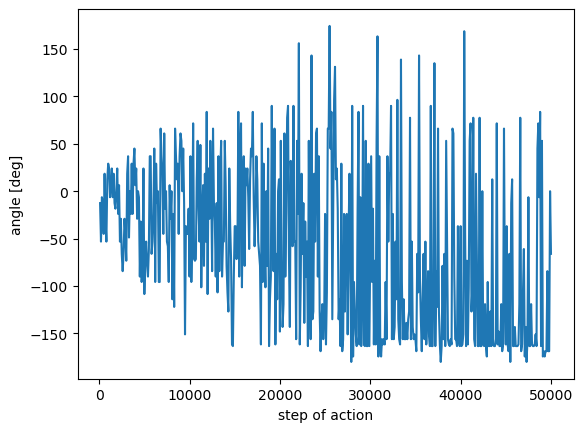

In [578]:
angle_deg=np.degrees(np.arctan2(obs_record[:,0],obs_record[:,1])) # (sin,cos)
plt.plot(step_count,angle_deg)
plt.xlabel('step of action')
plt.ylabel('angle [deg]')
plt.show()

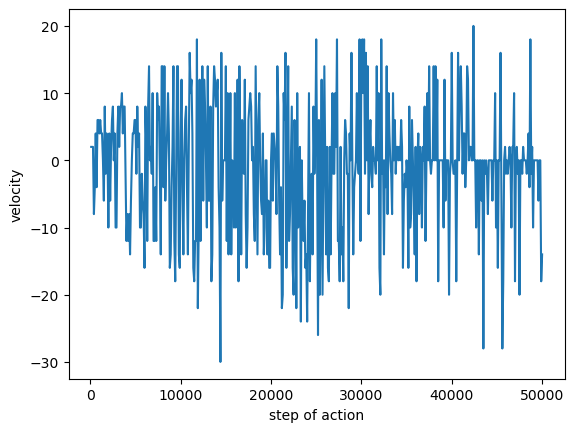

In [579]:
plt.plot(step_count,obs_record[:,2])
plt.xlabel('step of action')
plt.ylabel('velocity')
plt.show()

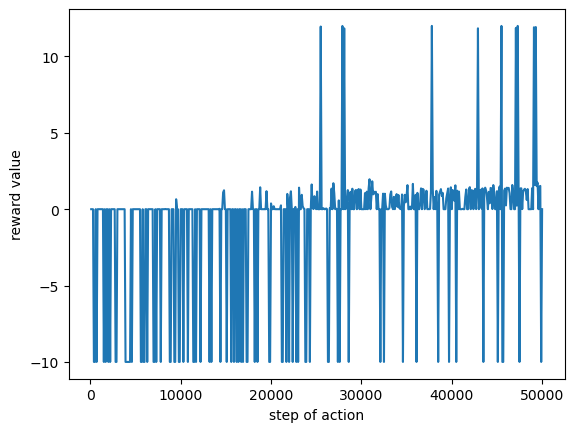

In [580]:
plt.plot(step_count,reward_record[:])
plt.xlabel('step of action')
plt.ylabel('reward value')
plt.show()

In [587]:
## load the Qmat (only for Qmat already saved)
#Qmat = np.load('Qmat_tabularQ.npy')

obs = env_new.reset()  # 
cum = 0
cum_rewards = []
reward_record =[]
th=[]
vel=[]
try:                   # 既然没法通过goal reach time来看出哪个更好，明显我们需要看数据！每隔一段时间打印state，而不是看流逝的时间！！ print state ,done
    env_new.render()    
    done= False
    while done==False:
        action = env_new.values_list[argmax([Qmat[obs,i] for i in env_new.values_list])]
        obs, reward, done, info = env_new.step(action)
        cum +=reward
        cum_rewards.append(cum)
        reward_record.append(reward)
        th.append(env_new.th%(2*np.pi)) 
        vel.append(env_new.omega)

        env.render()
        time.sleep(1/60)
        print(obs,reward,action,done,info)
finally:
    env_new.close()

# save the Qmat
np.save('Qmat_tabularQ.npy', Qmat)

(-0.0, 0.9, 0.0) 4.896222285742548e-22 1.0 False {}
(-0.0, 0.9, 2.0) 9.037241334522919e-22 1.0 False {}
(0.1, 0.9, 2.0) 2.3255390590695835e-21 1.0 False {}
(0.1, 0.9, 2.0) 7.598291974323689e-21 1.0 False {}
(0.1, 0.9, 2.0) 2.829387556946128e-20 1.0 False {}
(0.2, 0.9, 2.0) 1.0744525559466972e-19 1.0 False {}
(0.2, 0.9, 2.0) 3.749722275444541e-19 1.0 False {}
(0.3, 0.9, 2.0) 1.0998755540882728e-18 1.0 False {}
(0.3, 0.9, 0.0) 2.5290719072454906e-18 1.0 False {}
(0.3, 0.9, -2.0) -10.0 -3.0 False {}
(0.2, 0.9, -4.0) -10.0 -3.0 False {}
(0.1, 0.9, -4.0) -10.0 1.0 False {}
(-0.0, 0.9, -6.0) -10.0 -3.0 False {}
(-0.2, 0.9, -8.0) -10.0 -3.0 False {}
(-0.4, 0.9, -6.0) -10.0 -1.0 False {}
(-0.5, 0.9, -6.0) -9.999999999999996 -3.0 False {}
(-0.7, 0.7, -6.0) -9.999999999999732 -3.0 False {}
(-0.8, 0.6, -6.0) -9.999999999987425 -3.0 False {}
(-0.9, 0.5, -6.0) 3.057305046914046e-10 -3.0 False {}
(-0.9, 0.4, -4.0) 3.709636504927072e-09 -3.0 False {}
(-0.9, 0.3, -4.0) 2.2878506182351255e-08 -3.0 Fals

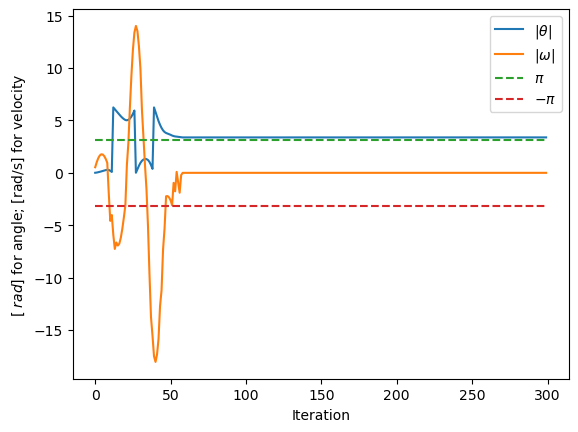

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


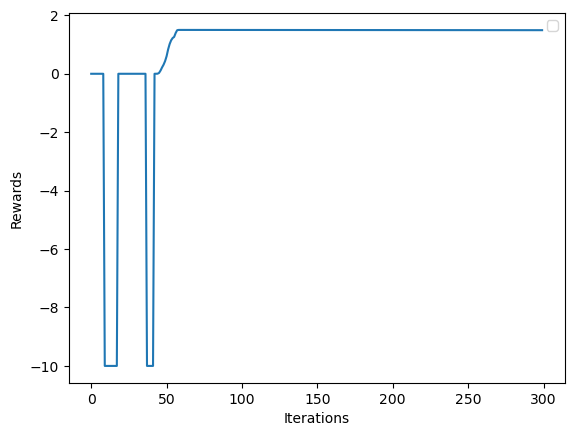

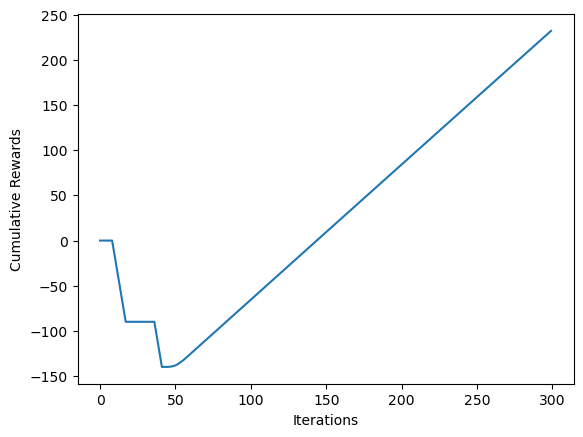

In [586]:
import matplotlib.pyplot as plt
plt.plot(th,label='$|\\theta|$')
plt.plot(vel,label='$|\omega|$')
plt.plot([np.pi]*len(th),'--',label='$\pi$')
plt.plot([-np.pi]*len(th),'--',label='$-\pi$')
plt.xlabel('Iteration')
plt.ylabel(r'[$\ rad$] for angle; [rad/s] for velocity')
plt.legend()
plt.show()

plt.plot(reward_record)
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_rewards)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()